In [85]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.linalg import solve_continuous_are, eigvals

In [56]:
def extract_terms(f,t,uI,uII):
    eps=1e-8
    d = len(uII)
    f_base = f(t, uI, uII)
    J = np.zeros((np.atleast_1d(f_base).shape[0], d))
    for i in range(d):
        uII_eps = np.array(uII, dtype=float)
        uII_eps[i] += eps
        diff = (f(t, uI, uII_eps) - f_base) / eps
        J[:, i] = diff.flatten()
    a1 = J
    a0 = f_base - a1 @ uII
    return a0, a1

In [57]:
def lorenz96_multiscale(u, v, dt, hc, hv, eps, F = 8):
    N,J = v.shape
    du = np.zeros(N)
    for i in range(N):
        du[i] = (u[(i+1)%N] - u[i-2]) * u[i-1] - u[i] + F -(hc/J)*np.sum(v[i])
    dv = np.zeros((N,J))
    for i in range(N):
        for j in range(J):
            dv[i,j] = (1/eps)*(hv*u[i] + v[i,(j+1)%J]*(v[i,(j-1)%J] - v[i,(j+2)%J]) - v[i,j])

    return u+ dt*du, v + dt*dv


In [ ]:
def kalman_bucy(d_uI, d_uII, t_span, uI, uII_0, R0=None, SigmaI=None, SigmaII=None,dt = None, dR = None):
    """ Implementation of the Kalman-Bucy filter for conditionally Gaussian systems

        Args:
            d_uI: function that returns the observation derivative given the state and input
            d_uII: function that returns the unknown state derivative given the state and input
            t_span: time span for the simulation
            uI: observed state
            uII_0: initial unknown state
            R0: initial covariance matrix (optional)
            SigmaI: process noise covariance matrix (optional)
            SigmaII: measurement noise covariance matrix (optional)
            dt: time step (optional, defaults to None, which will be calculated based on the length of x and t_span)
        Returns:
            A dictionary containing:
                - t: time values
                - uII: estimated state values
                - R: covariance matrix values
    """

    
    t0, tf = t_span
    n = len(uI)
    d = len(uII_0)
    print(d)
    t_vals = np.linspace(t0, tf, n)
    dt = (tf - t0) / (n-1) if dt is None else dt
    uII = np.zeros((d, n))
    uII[:,0] = uII_0
    R = np.zeros((n, d, d))
    R0 = np.eye(d) if R0 is None else R0
    R[0] = R0
    # m = len(uI[0])
    if SigmaI is not None:
        sst = SigmaI@SigmaI.T
        Sig_inv = np.linalg.inv(sst + np.eye(sst.shape[0])*1e-8 )
    else: 
        Sig_inv = np.zeros((len(uI[0]), len(uI[0])))
    
    if dR is None:
        dR = np.zeros_like(Sigma2)

    if SigmaII is not None:
        Sigma2 = SigmaII@SigmaII.T
    else: 
        Sigma2 = np.zeros((d, d))

    for i in tqdm(range(1, n)):
        A0,A1 = extract_terms(d_uI, t_vals[i], uI[i], uII[:,i-1])
        a0, a1 = extract_terms(d_uII, t_vals[i], uI[i], uII[:,i-1])


        duI = (uI[i] - uI[i-1])/dt

        innovation =duI - (A0 + (A1 @ uII[:,i-1]))
        
        K = (R[i-1] @ A1.T) @ Sig_inv

        uII[:,i] = uII[:,i-1] + dt*((a1@uII[:,i-1] + a0) + (K @ innovation))
        print(i, R[i-1])
        # R_temp = solve_continuous_are(a1.T, A1.T, Sigma2 - dR, sst)
        
        # R[i] = R[i-1] + (a1@R[i-1] + R[i-1]@ a1.T  + Sigma2 - R[i-1]@A1.T@Sig_inv@A1@R[i-1])*dt
        # print(R_temp.shape, R[i].shape)
        R[i] = R_temp
        # R[i] = R[i-1] + (a1@R[i-1] + R[i-1]@ a1.T  + Sigma2 - R[i-1]@A1.T@Sig_inv@A1@R[i-1])*dt
        if np.isnan(R).any():
            print(f"NaN detected at step {i}, filtering failed")

    return {"t": t_vals, "uII": uII, "R": R}

In [ ]:

N = 4
J = 8
F = 8
T = 6
hc = 1
hv = .5
n = 1000
eps = 1
x = 1.5*np.random.randn(N)  # initial condition
dt = T / (n-1)

# generate true system
X_true = np.random.randn(N)
Y_true = np.random.randn(N,J)
X_traj = np.zeros((n,N))
Y_traj = np.zeros((n,N,J))
X_traj[0] = X_true
Y_traj[0] = Y_true
for i in range(1,n):
    X_traj[i], Y_traj[i] = lorenz96_multiscale(X_traj[i-1], Y_traj[i-1],dt,hc,hv,eps,F)

obs_idx = np.arange(0,N)   # choose observed slow variables
hid_idx = np.arange(N,N+N*J)  # hide fast variables


uI_obs = X_traj[:, obs_idx] + np.random.randn(*X_traj[:, obs_idx].shape)   # observed
uII_0 = Y_traj[0].flatten()   # hidden
uII_0 = np.random.randn(len(uII_0))

def f_uI(t, uI, uII, hc = hc, J = J, F=8):
    """Derivative of slow, observed variables."""
    N = len(uI)
    slow_vars = np.zeros(N)
    slow_vars[obs_idx] = uI
    du = np.zeros_like(uI)
    fast_vars = uII.reshape((N,J))
    for k in range(len(uI)):
        i = obs_idx[k]
        du[k] = (slow_vars[(i+1)%N] - slow_vars[i-2]) * slow_vars[i-1] - slow_vars[i] + F -(hc/J)*np.sum(fast_vars[i])
    return du

def f_uII(t, uI, uII, hv = hv, J = J, eps = eps, F=8):
    """Derivative of fast, hidden variables and unobserved slow variables."""
    N = len(uI) 
    slow_vars = np.zeros(N)
    slow_vars[obs_idx] = uI
    dv = np.zeros_like(uII)
    fast_vars = uII.reshape((N,J))
    for i in range(N):
        for j in range(J):
            dv[(i*J) + j] = (1/eps)*(hv*slow_vars[i] + fast_vars[i,(j+1)%J]*(fast_vars[i,j-1] - fast_vars[i,(j+2)%J]) - fast_vars[i,j])

    return dv.flatten()

t_span = (0, T)
t =  np.linspace(t_span[0], t_span[1], n)

N_fast = len(hid_idx)
SigmaI=0.1*np.eye(len(obs_idx))
SigmaII=1*np.eye(len(uII_0))

# R0 = np.zeros((N_fast,N_fast))
# fast variables
R0 = 0.1 * np.eye(N_fast)

uI_op = np.mean(uI_obs, axis=0)
# A0,A1 = extract_terms(d_uI, t_vals[i], uI[i], uII[:,i-1])
# a0, a1 = extract_terms(d_uII, t_vals[i], uI[i], uII[:,i-1])
uII_op = np.mean(Y_traj, axis=0).flatten()
A0, A1_op = extract_terms(f_uI, 0, uI_op, uII_op)
a0, a1_op = extract_terms(f_uII, 0, uI_op, uII_op)
print(A1_op.shape, a1_op.shape)
Q = SigmaII @ SigmaII.T
Rv = SigmaI @ SigmaI.T
P = solve_continuous_are(a1_op.T, A1_op.T, Q, Rv)

results = kalman_bucy(
    d_uI=lambda t,uI,uII: f_uI(t,uI,uII),
    d_uII=lambda t,uI,uII: f_uII(t,uI,uII),
    t_span=t_span,
    uI=uI_obs,
    uII_0=uII_0,
    R0=R0,
    SigmaI=SigmaI,
    SigmaII=SigmaII,
    dt=dt,
    dR=0
)

uII_est = results['uII']

t_vals = results['t']

y_traj = Y_traj.reshape(n,N*J).T


# # plot unobserved slow variables
# plt.figure(figsize=(10,5))
# for i, idx in enumerate(obs_idx):
#     plt.plot(t_vals, X_traj[:, idx], label=f'True slow x{idx}')
#     plt.plot(t_vals, uII_est[i], '--', label=f'Estimated slow x{idx}')
# plt.xlabel("Time")
# plt.ylabel("Hidden Slow States")
# plt.legend()
# plt.title("Observed Slow Variables")
# plt.grid()
# plt.show()

plt.figure(figsize=(12,6))

# plot first few fast variables
num_fast_to_plot = 6
for i in range(num_fast_to_plot):
    plt.plot(t_vals, Y_traj[:, i//J, i%J], label=f'True fast y{i}')
    plt.plot(t_vals, uII_est[i], '--', label=f'Estimated fast y{i}')

plt.xlabel("Time")
plt.ylabel("Hidden States")
plt.title("Hidden Fast Variables")
plt.legend(ncol=2, fontsize=8)
plt.grid()
plt.show()




(4, 32) (32, 32)
32


  1%|          | 8/999 [00:00<00:06, 159.76it/s]

1 [[0.1 0.  0.  ... 0.  0.  0. ]
 [0.  0.1 0.  ... 0.  0.  0. ]
 [0.  0.  0.1 ... 0.  0.  0. ]
 ...
 [0.  0.  0.  ... 0.1 0.  0. ]
 [0.  0.  0.  ... 0.  0.1 0. ]
 [0.  0.  0.  ... 0.  0.  0.1]]
2 [[ 1.02829476e+00 -3.16254950e-01 -4.97517838e-01 ...  3.22742099e-16
  -5.28519890e-17  2.94632987e-16]
 [-3.16254950e-01  8.14681657e-01  1.47478467e-01 ... -1.42214250e-15
   5.95157623e-16 -1.13428562e-15]
 [-4.97517838e-01  1.47478467e-01  6.63617967e-01 ... -5.12275591e-16
   7.05242025e-17 -7.13049877e-17]
 ...
 [ 3.22742099e-16 -1.42214250e-15 -5.12275591e-16 ...  6.96971569e-01
  -2.15099024e-01  8.25868207e-02]
 [-5.28519890e-17  5.95157623e-16  7.05242025e-17 ... -2.15099024e-01
   8.51068471e-01 -2.47256699e-01]
 [ 2.94632987e-16 -1.13428562e-15 -7.13049877e-17 ...  8.25868207e-02
  -2.47256699e-01  6.06566926e-01]]
3 [[ 1.01190524e+00 -3.04459623e-01 -4.74970673e-01 ...  3.66529570e-16
  -2.37168830e-16 -5.54679663e-16]
 [-3.04459623e-01  8.26119161e-01  1.27490796e-01 ... -9.0887

LinAlgError: Failed to find a finite solution.

In [ ]:
print(results['R'])

[[[0.125 0.    0.    ... 0.    0.    0.   ]
  [0.    0.125 0.    ... 0.    0.    0.   ]
  [0.    0.    0.125 ... 0.    0.    0.   ]
  ...
  [0.    0.    0.    ... 0.125 0.    0.   ]
  [0.    0.    0.    ... 0.    0.125 0.   ]
  [0.    0.    0.    ... 0.    0.    0.125]]

 [[0.125 0.    0.    ... 0.    0.    0.   ]
  [0.    0.125 0.    ... 0.    0.    0.   ]
  [0.    0.    0.125 ... 0.    0.    0.   ]
  ...
  [0.    0.    0.    ... 0.125 0.    0.   ]
  [0.    0.    0.    ... 0.    0.125 0.   ]
  [0.    0.    0.    ... 0.    0.    0.125]]

 [[0.125 0.    0.    ... 0.    0.    0.   ]
  [0.    0.125 0.    ... 0.    0.    0.   ]
  [0.    0.    0.125 ... 0.    0.    0.   ]
  ...
  [0.    0.    0.    ... 0.125 0.    0.   ]
  [0.    0.    0.    ... 0.    0.125 0.   ]
  [0.    0.    0.    ... 0.    0.    0.125]]

 ...

 [[0.125 0.    0.    ... 0.    0.    0.   ]
  [0.    0.125 0.    ... 0.    0.    0.   ]
  [0.    0.    0.125 ... 0.    0.    0.   ]
  ...
  [0.    0.    0.    ... 0.125 0.    0. 

In [71]:
def EM(x0, T = 100, timesteps = 10000, c = 10):
    delta_t = T/timesteps
    rho = 28
    beta = 8/3
    sigma = 10
    final = np.zeros((timesteps,3))
    final[0] = x0
    for i in range(timesteps-1):
        final[i+1, 0] = final[i,0] + delta_t*(sigma*(final[i,1]-final[i,0]))
        final[i+1, 1] = final[i,1] + delta_t*(final[i,0]*(rho - final[i,2])-final[i,1]) + c*np.random.normal(0,np.sqrt(delta_t))
        final[i+1, 2] = final[i,2] + delta_t*(final[i,0]*final[i,1]-beta*final[i,2])

    return final

sol = EM([0,1,0])
x = sol[:,0]
y = sol[:,1]
z = sol[:,2]

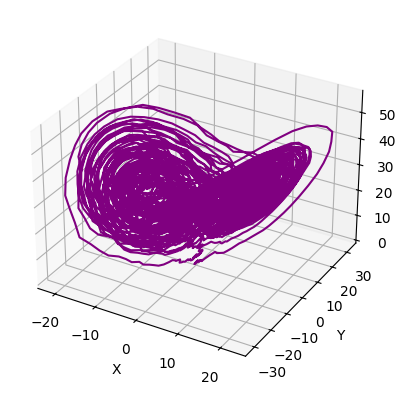

2


100%|██████████| 9999/9999 [00:01<00:00, 5719.00it/s]


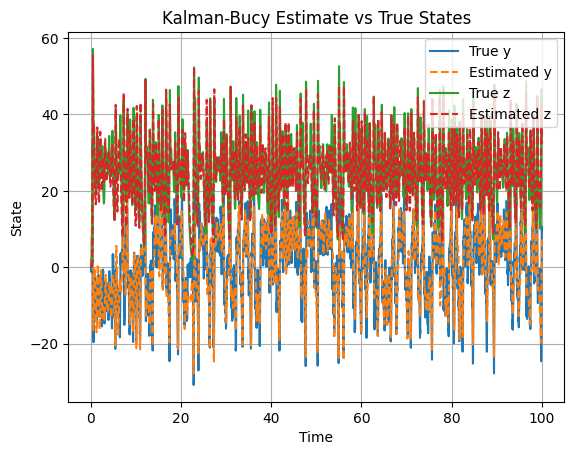

In [80]:

def f_uI(t, uI, uII):
    # uI is the state of the observed variable (x)
    sigma = 10
    return sigma * (uII[0] - uI)

def f_uII(t, uI, uII):
    # uII is the state of the unobserved variables (y, z)
    rho, beta = 28, 8 / 3
    y, z = uII
    x = uI
    return np.array([
        -y - x * z + rho * x,
        x * y - beta * z
    ])

# Simulation parameters
T = 100
t_span = (0, T)
n = len(x)
# uI = x.copy().reshape(n,1)
uI = x.copy()
t =  np.linspace(t_span[0], t_span[1], n)


# Run Kalman-Bucy filter
results = kalman_bucy(
    d_uI=f_uI,
    d_uII=f_uII,
    t_span=t_span,
    uI=uI,
    uII_0=np.array([1, 0]),
    R0=.5*np.eye(2),
    SigmaI=np.array([[1]]),
    SigmaII=np.diag([0.1, 0.1]),
    dt = (T/(n-1)),
    dR = 0
)

# Access results
uII_est = results["uII"]
t_vals = results["t"]


plt.plot(t_vals, y, label="True y")
plt.plot(t_vals, uII_est[0], '--', label="Estimated y")
plt.plot(t_vals, z, label="True z")
plt.plot(t_vals, uII_est[1], '--', label="Estimated z")
plt.xlabel("Time")
plt.ylabel("State")
plt.legend()
plt.title("Kalman-Bucy Estimate vs True States")
plt.grid()
plt.show()


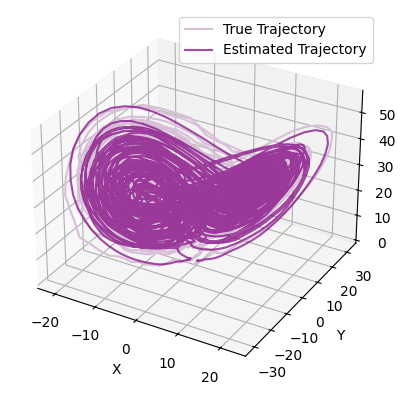

In [81]:
fig = plt.figure()

ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.plot(x,y,z, 'thistle', alpha=1, label='True Trajectory')

ax.plot(x,uII_est[0],uII_est[1], 'purple', alpha=0.7, label='Estimated Trajectory')

ax.set_xlabel('X')
ax.set_zlabel('Z')
plt.ylabel('Y')
plt.legend()
plt.show()